In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sea
from tqdm import tqdm  # instead of tqdm.notebook
from tqdm.notebook import tqdm
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn.functional as F
import torchmetrics
from torchmetrics import Metric
import torchvision
from torchvision import models
import cv2 as op
import seaborn as sns

plt.style.use('ggplot') 
device = 'cuda' if torch.cuda.is_available() else 'cpu'

np.__version__, device

('1.25.2', 'cpu')

In [9]:
TRAIN_PATH = r'C:\Users\HP\Downloads\archive\dataset\Train'

TEST_PATH = r'C:\Users\HP\Downloads\archive\dataset\Test'
def load_data(PATH):
    filenames, fruit, fresh = [], [], []
    
    for file in tqdm(os.listdir(PATH)):
        for img in os.listdir(os.path.join(PATH, file)):
            fresh.append(1 if file[0] == 'f' else 0)
            fruit.append(file[5:] if file[0] == 'f' else file[6: ])
            filenames.append(os.path.join(PATH, file, img))
            
    df = pd.DataFrame({
        'filename' : filenames,
        'fruit' : fruit,
        'fresh' : fresh
    })
    
    return df

df_train = load_data(TRAIN_PATH).sample(frac = 1)
df_test = load_data(TEST_PATH).sample(frac = 1)

df_train.shape, df_test.shape
    









100%|██████████| 18/18 [00:01<00:00, 14.01it/s]



100%|██████████| 14/14 [00:00<00:00, 62.65it/s]


((23618, 3), (6738, 3))

In [10]:
df_test['fruit'] = df_test['fruit'].map(lambda x : 'tomato' if x == 'tamto' else x)
df_test['fruit'] = df_test['fruit'].map(lambda x : 'potato' if x == 'patato' else x)

In [11]:
df = pd.concat([df_train, df_test], axis = 0)
df.shape

(30356, 3)

<Axes: xlabel='fruit', ylabel='count'>

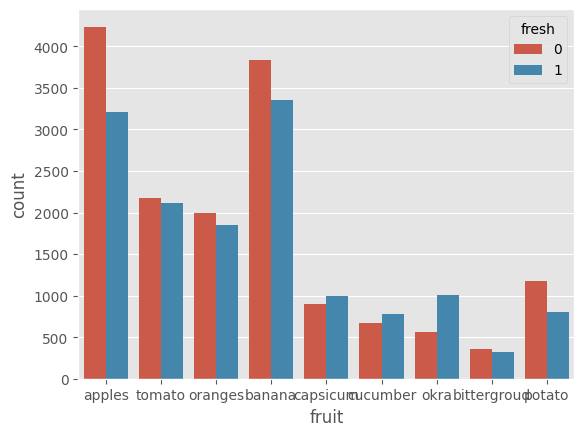

In [12]:
sea.countplot(x = 'fruit', data = df, hue = 'fresh')

In [13]:
counts = df['fruit'].value_counts()
df_new = pd.DataFrame(columns= ['filename', 'fruit', 'fresh'])

for (key, value) in counts.items():
    if value > 1500:
        df_temp = df[df['fruit'] == key].sample(n = 1500)
    else:
        df_temp = df[df['fruit'] == key]
        
    df_new = pd.concat([df_new, df_temp], axis = 0)  
    
df_new.shape

(12635, 3)

In [14]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

df_new['fruit_label'] = le.fit_transform(df_new['fruit'])
df_new.shape

(12635, 4)

In [15]:
df_new.head()

,filename,fruit,fresh,fruit_label
12828,C:\Users\HP\Downloads\archive\dataset\Train\ro...,apples,0,0
12035,C:\Users\HP\Downloads\archive\dataset\Train\ro...,apples,0,0
410,C:\Users\HP\Downloads\archive\dataset\Train\fr...,apples,1,0
4005,C:\Users\HP\Downloads\archive\dataset\Test\rot...,apples,0,0
54,C:\Users\HP\Downloads\archive\dataset\Test\fre...,apples,1,0


<Axes: xlabel='fruit', ylabel='count'>

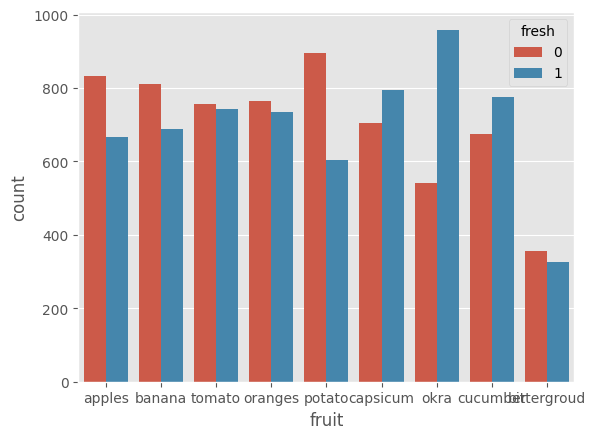

In [16]:
sea.countplot(x = 'fruit', data = df_new, hue = 'fresh')

In [17]:
from sklearn.model_selection import train_test_split

df_train, df_val = train_test_split(df_new, test_size = 0.15, stratify = df_new['fruit_label'])

df_train.shape, df_val.shape

((10739, 4), (1896, 4))

<Axes: xlabel='fruit_label', ylabel='count'>

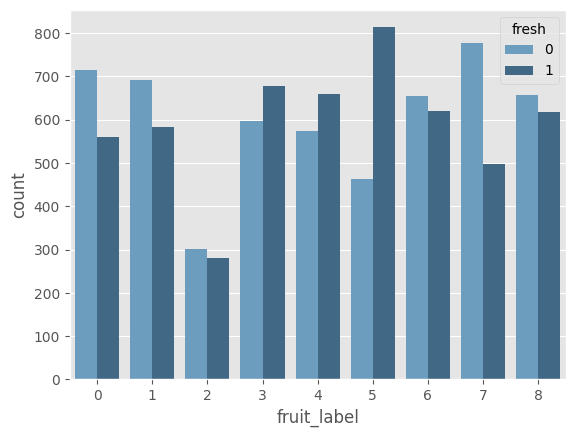

In [18]:
sea.countplot(x = 'fruit_label', data = df_train, hue = 'fresh', palette = 'Blues_d')

<Axes: xlabel='fruit', ylabel='count'>

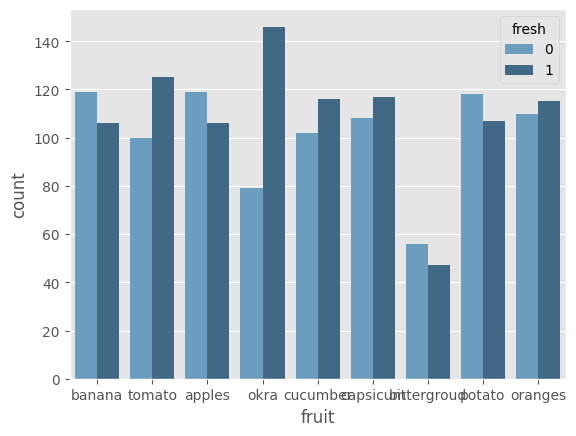

In [19]:
sea.countplot(x = 'fruit', data = df_val, hue = 'fresh', palette = 'Blues_d')

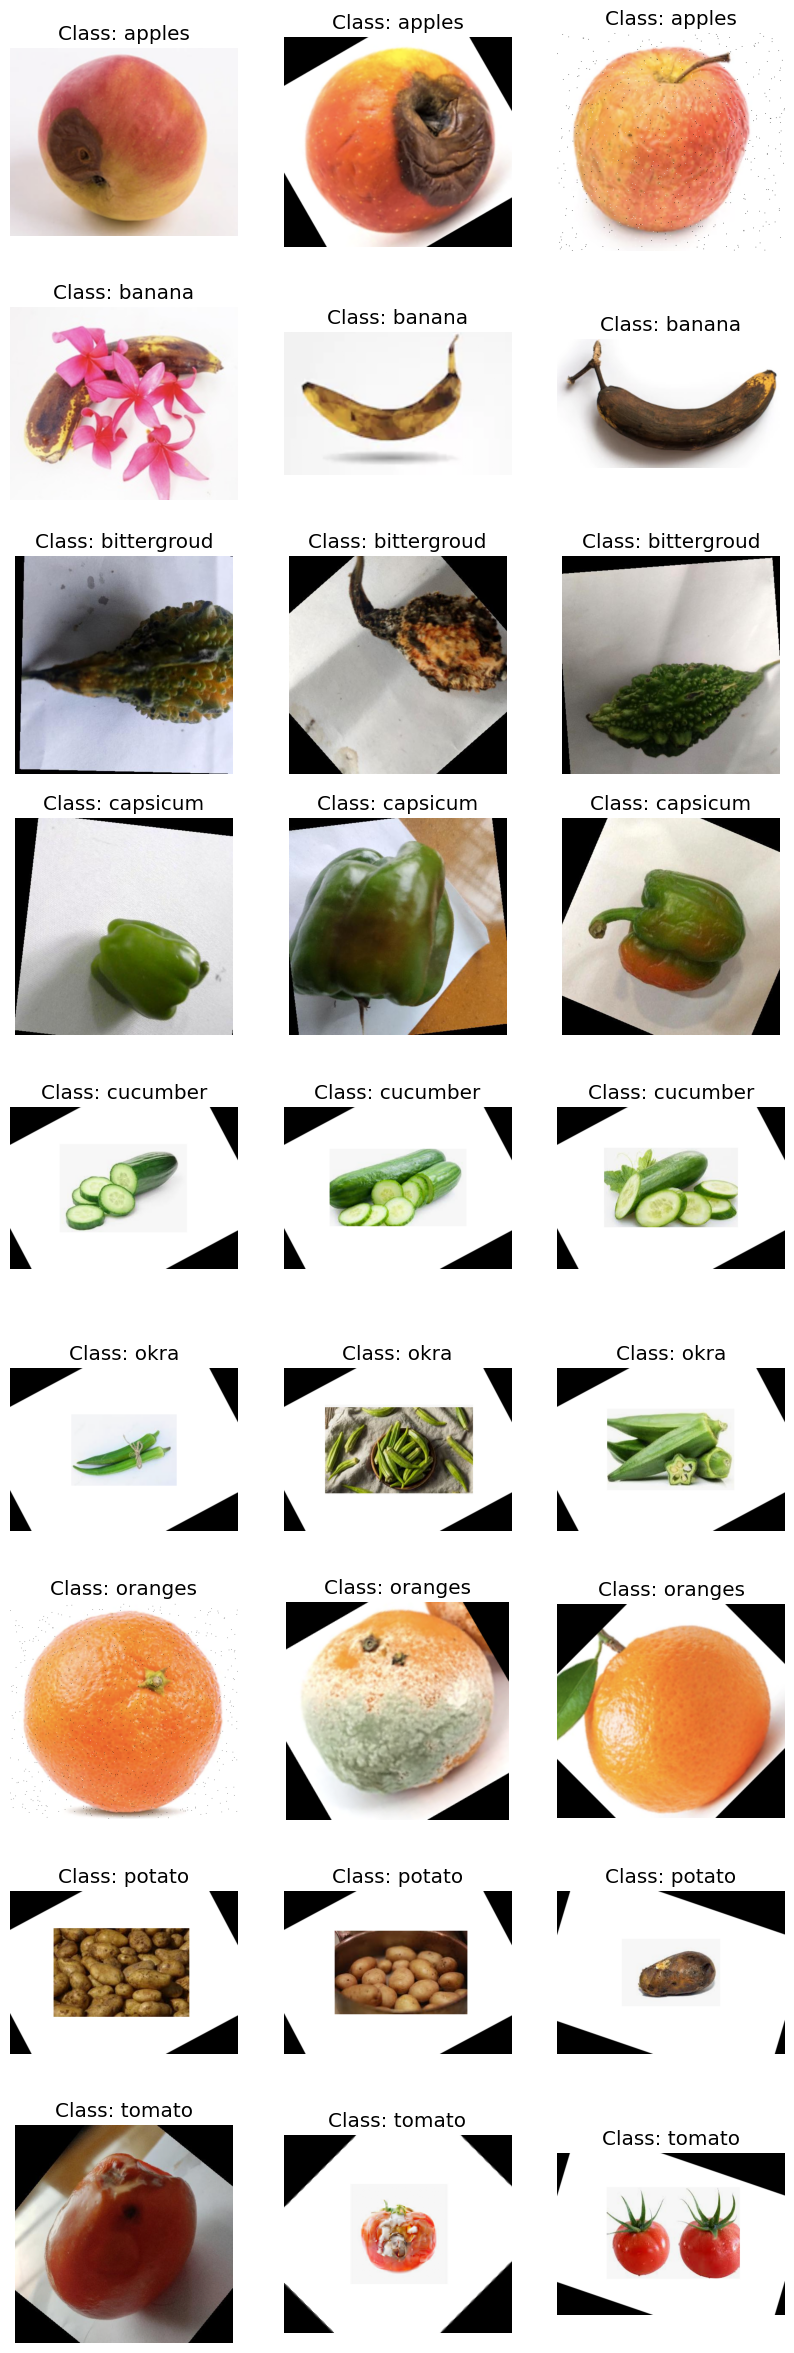

In [21]:
def load_image(path):
    img = plt.imread(path)
    return img

counter = 0

plt.figure(figsize = (10, 30))

for i in range(9):
    for path in df_train[df_train['fruit_label'] == i].sample(n = 3)['filename']:
        plt.subplot(9, 3, counter + 1)
        img = load_image(path)
        plt.imshow(img)
        plt.axis('off')
        plt.title('Class:' + " " + le.inverse_transform([i])[0])
        counter += 1
        

In [22]:
def image_transform(img, p = 0.5, training = True):    
    if training:
        img = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(p = p),
            transforms.GaussianBlur(3, sigma=(0.1, 2.0)),
            transforms.RandomAdjustSharpness(3, p = p),
            transforms.Normalize(mean = 0, std = 1)
        ])(img)
    else:
        img = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((224, 224)),
            transforms.Normalize(mean = 0, std = 1)
        ])(img)

    return img

class FruitDataset:
    def __init__(self, df, training):
        self.df = df
        self.n_samples = len(self.df)
        self.training = training
        
    def __len__(self):
        return self.n_samples
    
    def __getitem__(self, idx):
        img = plt.imread(self.df.iloc[idx][0])[:, :, :3]
        fresh = torch.tensor(self.df.iloc[idx][2])
        fruit = torch.tensor(self.df.iloc[idx][3])

        img = image_transform(img, p = 0.5, training = self.training)
            
        return img, fruit, fresh
    

In [23]:
BATCH_SIZE = 64


train_dataset = FruitDataset(df_train, training = True)
val_dataset = FruitDataset(df_val, training = False)

train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE)

In [24]:
a, b, c = next(iter(train_loader))
print(a.shape, b.shape, c.shape)
del(a)
del(b)
del(c)

C:\Users\HP\AppData\Local\Temp\ipykernel_7220\2081510745.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  img = plt.imread(self.df.iloc[idx][0])[:, :, :3]
C:\Users\HP\AppData\Local\Temp\ipykernel_7220\2081510745.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  fresh = torch.tensor(self.df.iloc[idx][2])
C:\Users\HP\AppData\Local\Temp\ipykernel_7220\2081510745.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  fruit = torch.

torch.Size([64, 3, 224, 224]) torch.Size([64]) torch.Size([64])


In [86]:
import math

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.alpha = 0.7
        
        self.base = torchvision.models.resnet18(pretrained = True)
        
        for param in list(self.base.parameters())[:-15]:
            param.requires_grad = False
                    
        self.base.classifier = nn.Sequential()
        self.base.fc = nn.Sequential()
            
        self.block1 = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
        )
        
        self.block2 = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, 9)
        )
        
        self.block3 = nn.Sequential(
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(32, 2)
        )

        self.optimizer1 = torch.optim.Adam([
            {'params' : self.base.parameters(), 'lr': 1e-5},
            {'params' : self.block1.parameters(),  'lr': 3e-4}
        ])
        
        self.optimizer2 = torch.optim.Adam(self.block2.parameters(), lr = 3e-4)
        self.optimizer3 = torch.optim.Adam(self.block3.parameters(), lr = 3e-4)
        
        self.loss_fxn = nn.CrossEntropyLoss()
        self.fruit_accuracy = torchmetrics.Accuracy(task='multiclass', num_classes = 9)
        self.fresh_accuracy = torchmetrics.Accuracy(task = 'multiclass', num_classes = 2)
        
        self.TRAIN_BATCHES = math.ceil(len(train_dataset)/BATCH_SIZE)
        self.VAL_BATCHES = math.ceil(len(val_dataset)/BATCH_SIZE)

        self.history = {'train_loss': [], 'val_loss': [], 
                    'train_acc_fruit': [], 'train_acc_fresh': [],
                    'val_acc_fruit': [], 'val_acc_fresh': []}
    
        
    def forward(self, x):
        x = self.base(x)
        x = self.block1(x)
        y1, y2 = self.block2(x), self.block3(x)
        
        return y1, y2

    
    def train_step(self, x, y1, y2):
        pred1, pred2 = self.forward(x)
        l1, l2 = self.loss_fxn(pred1, y1), self.loss_fxn(pred2, y2)

        self.optimizer2.zero_grad()
        l1.backward(retain_graph = True)
        self.optimizer2.step()
        
        self.optimizer3.zero_grad()
        l2.backward(retain_graph = True)
        self.optimizer3.step()
        
        
        loss = self.alpha * l1 + (1 - self.alpha) * l2
        self.optimizer1.zero_grad()
        loss.backward()
        self.optimizer1.step()
        
        fruit_acc = self.fruit_accuracy(torch.argmax(pred1, axis = 1), y1)
        fresh_acc = self.fresh_accuracy(torch.argmax(pred2, axis = 1), y2)
        
        return loss, fruit_acc, fresh_acc
    
    def val_step(self, x, y1, y2):
        with torch.no_grad():
            pred1, pred2 = self.forward(x)
            loss = self.alpha * self.loss_fxn(pred1, y1) + (1 - self.alpha) * self.loss_fxn(pred2, y2)

            fruit_acc = self.fruit_accuracy(torch.argmax(pred1, axis = 1), y1)
            fresh_acc = self.fresh_accuracy(torch.argmax(pred2, axis = 1), y2)
            return loss, fruit_acc, fresh_acc
        
    def update_history(self, train_loss, train_fruit, train_fresh, val_loss, val_fruit, val_fresh):
        self.history['train_loss'].append(train_loss)
        self.history['val_loss'].append(val_loss)
        self.history['train_acc_fresh'].append(train_fresh)
        self.history['train_acc_fruit'].append(train_fruit)
        self.history['val_acc_fresh'].append(val_fresh)
        self.history['val_acc_fruit'].append(val_fruit)
        
        
    def train(self, epochs = 5):
        
        for epoch in tqdm(range(epochs)):
            
            train_loss, train_fruit, train_fresh = 0, 0, 0
            val_loss, val_fruit, val_fresh = 0, 0, 0
            
            for X, y1, y2 in tqdm(train_loader):
                X, y1, y2 = [v.to(device) for v in (X, y1, y2)]
                loss, fruit_acc, fresh_acc = self.train_step(X, y1, y2)
                train_loss += loss.item()
                train_fruit += fruit_acc.item()
                train_fresh += fresh_acc.item()
                
            for X, y1, y2 in tqdm(val_loader):
                X, y1, y2 = [v.to(device) for v in (X, y1, y2)]
                loss, fruit_acc, fresh_acc = self.val_step(X, y1, y2)
                val_loss += loss.item()
                val_fruit += fruit_acc.item()
                val_fresh += fresh_acc.item()
                
            train_loss, train_fruit, train_fresh = [x/self.TRAIN_BATCHES for x in (train_loss, train_fruit, train_fresh)]
            val_loss, val_fruit, val_fresh = [x/self.VAL_BATCHES for x in (val_loss, val_fruit, val_fresh)]
            
            self.update_history( train_loss, train_fruit, train_fresh, val_loss, val_fruit, val_fresh)
            
            print("[Epoch: {}] Train: [loss: {:.3f}, fruit: {:.3f} fresh: {:.3f}] Val: [loss: {:.3f}, fruit: {:.3f} fresh: {:.3f}]".format(epoch, train_loss, train_fruit, train_fresh, 
                                                                                                                                          val_loss, val_fruit, val_fresh))

In [89]:
model = Model().to(device)

In [90]:
model.train(epochs = 6)


  0%|          | 0/6 [00:00<?, ?it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_7220\2081510745.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  img = plt.imread(self.df.iloc[idx][0])[:, :, :3]
C:\Users\HP\AppData\Local\Temp\ipykernel_7220\2081510745.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  fresh = torch.tensor(self.df.iloc[idx][2])
C:\Users\HP\AppData\Local\Temp\ipykernel_7220\2081510745.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position,

RuntimeError: expected scalar type Long but found Int

In [32]:
def train_step(self, x, y1, y2):
    pred1, pred2 = self.forward(x)
    
    # Ensure target tensors are of type Long
    y1 = y1.long()
    y2 = y2.long()
    
    l1, l2 = self.loss_fxn(pred1, y1), self.loss_fxn(pred2, y2)
    
    self.optimizer2.zero_grad()
    l1.backward(retain_graph=True)
    l2.backward()
    
    return l1 + l2, self.accuracy(pred1, y1), self.accuracy(pred2, y2)


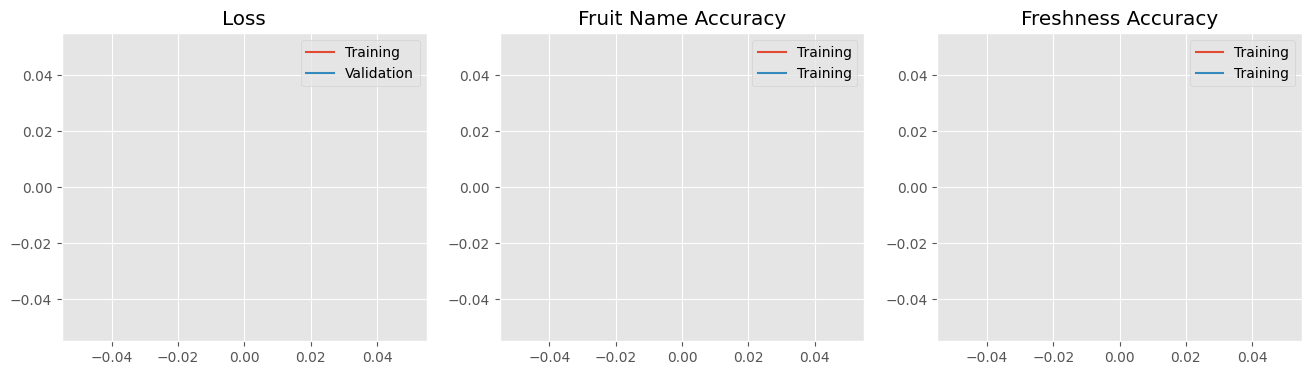

In [37]:
plt.figure(figsize = (16, 4))

plt.subplot(1,3,1)
plt.title('Loss')
plt.plot(model.history['train_loss'], label = 'Training')
plt.plot(model.history['val_loss'], label = 'Validation')
plt.legend()

plt.subplot(1,3,2)
plt.title('Fruit Name Accuracy')
plt.plot(model.history['train_acc_fruit'], label = 'Training')
plt.plot(model.history['val_acc_fruit'], label = 'Training')
plt.legend()

plt.subplot(1,3,3)
plt.title('Freshness Accuracy')
plt.plot(model.history['train_acc_fresh'], label = 'Training')
plt.plot(model.history['val_acc_fresh'], label = 'Training')
plt.legend()

In [38]:
preds1, preds2, fruit, fresh = [], [], [], []

with torch.no_grad():
    for x, y1, y2 in tqdm(val_loader):
        pred = model(x.to(device))
        
        pred1 = torch.argmax(pred[0], axis = 1).detach().cpu().numpy()
        pred2 = torch.argmax(pred[1], axis = 1).detach().cpu().numpy()
        preds1.extend(pred1)
        preds2.extend(pred2)
        fruit.extend(y1)
        fresh.extend(y2)
        
        
len(fruit), len(fresh), len(preds1), len(preds2)

  0%|          | 0/30 [00:00<?, ?it/s]C:\Users\HP\AppData\Local\Temp\ipykernel_7220\2081510745.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  img = plt.imread(self.df.iloc[idx][0])[:, :, :3]
C:\Users\HP\AppData\Local\Temp\ipykernel_7220\2081510745.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  fresh = torch.tensor(self.df.iloc[idx][2])
C:\Users\HP\AppData\Local\Temp\ipykernel_7220\2081510745.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position

(1896, 1896, 1896, 1896)

Text(0.5, 1.0, 'Confusion Matrix for Fruit Names')

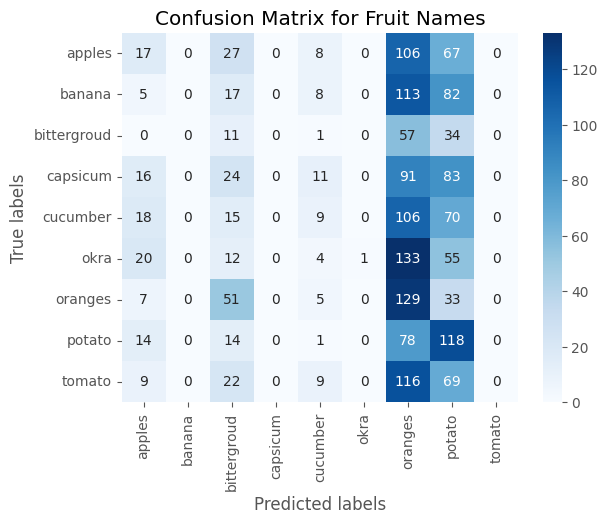

In [39]:
from sklearn.metrics import confusion_matrix

class_names = le.inverse_transform(np.arange(0, 9))

cm = confusion_matrix(fruit, preds1)
sea.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, xticklabels = class_names, yticklabels = class_names)

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Fruit Names')


Text(0.5, 1.0, 'Confusion Matrix for Freshness')

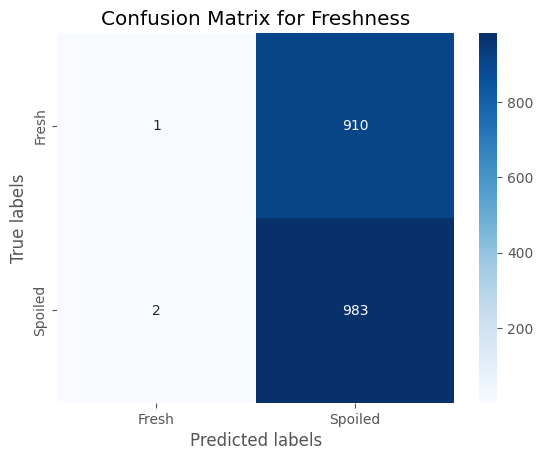

In [91]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(fresh, preds2)
sea.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, xticklabels = ['Fresh', 'Spoiled'], yticklabels = ['Fresh', 'Spoiled'])

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Freshness')

In [92]:
from sklearn.metrics import classification_report

print(classification_report(fruit, preds1, target_names = class_names))
print(classification_report(fresh, preds2, target_names = ['Fresh', 'Spoiled']))

              precision    recall  f1-score   support

      apples       0.16      0.08      0.10       225
      banana       0.00      0.00      0.00       225
 bittergroud       0.06      0.11      0.07       103
    capsicum       0.00      0.00      0.00       225
    cucumber       0.16      0.04      0.07       218
        okra       1.00      0.00      0.01       225
     oranges       0.14      0.57      0.22       225
      potato       0.19      0.52      0.28       225
      tomato       0.00      0.00      0.00       225

    accuracy                           0.15      1896
   macro avg       0.19      0.15      0.08      1896
weighted avg       0.20      0.15      0.08      1896

              precision    recall  f1-score   support

       Fresh       0.33      0.00      0.00       911
     Spoiled       0.52      1.00      0.68       985

    accuracy                           0.52      1896
   macro avg       0.43      0.50      0.34      1896
weighted avg       0.43

c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f